Inspired from:

- [Model Convolution: A Computational Approach to Digital Image Interpretation, 2010](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2864900/)

In [1]:
%matplotlib inline

from pathlib import Path
import sys
sys.path.append("..")

import anamic

import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipyvolume as ipv
import skimage

def imshow_cb(im, ax):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    
    img = ax.imshow(im, interpolation='none', origin=[0, 0])
    ax.set_aspect('equal')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(img, cax=cax)

../anamic/transformations.py:1916: UserWarning: No module named 'anamic._transformations'
  warnings.warn(str(err))


In [178]:
# Define the structure of the MT
# as a 2D array where:
# - x corresponds to rows of dimers.
# - y corresponds to each protofilaments.

n_pf = 13
long_dimer_distance = 8  # nm
mt_length = 4000  # nm
taper_length_nm = 200  # nm
n_rows = int(np.round(mt_length / long_dimer_distance))
print(n_rows)

dimers = np.ones((n_pf, n_rows))
dimers = anamic.structure.generate_uniform_taper(dimers, taper_length_nm=taper_length_nm)

#_ = anamic.viz.viz_dimers(dimers, start_row=-200, grid=True)

# Calculate the x, y and z positions of each dimers.
positions = anamic.structure.get_dimer_positions(dimers)

# Apply a random rotation parallell to the surface (along the z axis)
# This is to avoid having the seam always at the same location.
rotation = np.deg2rad(np.random.randn() * 360)
Rz = anamic.transformations.rotation_matrix(rotation, [0, 0, 1])
positions[['x', 'y', 'z']] = np.dot(positions[['x', 'y', 'z']].values, Rz[:3, :3].T)

# Apply a certain labeling ratio
labeling_ratio = 0.1
positions['labeled'] = np.random.random(positions.shape[0]) < labeling_ratio

anamic.viz.viz_dimer_positions(positions, size=0.4, color_feature_name='pf')

500


(3744.9385112205086, 3949.9385112205086)

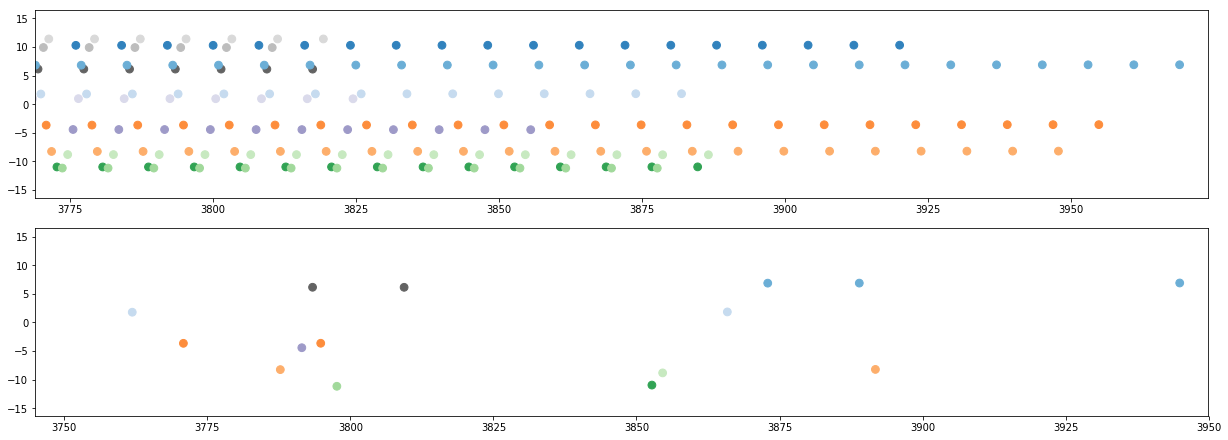

In [179]:
# Visualize projected dimer positions on a plan.

# We choose the XZ plan for projection so no need to project positions.

positions[['x_proj', 'y_proj']] = positions[['x', 'z']].copy()

color_feature_name = 'pf'
marker_size = 60
colormap = 'tab20c'

fig, axs = plt.subplots(nrows=2, figsize=(18, 6), constrained_layout=True)

selected_dimers = positions[(positions['visible'] == True)]
axs[0].scatter(selected_dimers['y_proj'], selected_dimers['x_proj'], c=selected_dimers[color_feature_name],s=marker_size, cmap=colormap)
axs[0].set_aspect('equal')
axs[0].set_ylim(selected_dimers['x_proj'].min() - 5, selected_dimers['x_proj'].max() + 5)
axs[0].set_xlim(selected_dimers['y_proj'].max() - 200, selected_dimers['y_proj'].max() + 5)

selected_dimers = positions[(positions['visible'] == True) & (positions['labeled'] == True)]
axs[1].scatter(selected_dimers['y_proj'], selected_dimers['x_proj'], c=selected_dimers[color_feature_name], s=marker_size, cmap=colormap)
axs[1].set_aspect('equal')
axs[1].set_ylim(selected_dimers['x_proj'].min() - 5, selected_dimers['x_proj'].max() + 5)
axs[1].set_xlim(selected_dimers['y_proj'].max() - 200, selected_dimers['y_proj'].max() + 5)

In [180]:
# Apply a random rotation of the projected microtubule
Rx = anamic.transformations.rotation_matrix(np.deg2rad(np.random.randn() * 180), [1, 0, 0])
Ry = anamic.transformations.rotation_matrix(np.deg2rad(np.random.randn() * 180), [0, 1, 0])
R = anamic.transformations.concatenate_matrices(Rx, Ry)

positions['x_proj_rotated'] = np.nan
positions['y_proj_rotated'] = np.nan
positions[['x_proj_rotated', 'y_proj_rotated']] = np.dot(positions[['x_proj', 'y_proj']].values, R[1:3, 1:3].T)
#positions[['x_proj_rotated', 'y_proj_rotated']] = positions[['x_proj', 'y_proj']].copy()

In [181]:
# Discretize dimers onto an high resolution image

microscope_pixel_size = 110  # nm/pixel
pixel_size_ratio = 10
fine_pixel_size = microscope_pixel_size / pixel_size_ratio
print(fine_pixel_size)
assert int(fine_pixel_size) == fine_pixel_size

x_offset = 800  # nm
y_offset = 800  # nm

x_max = int(np.round(positions['x_proj_rotated'].max() + 1))
x_min = int(np.round(positions['x_proj_rotated'].min() - 1))
y_max = int(np.round(positions['y_proj_rotated'].max() + 1))
y_min = int(np.round(positions['y_proj_rotated'].min() - 1))

x_bins = np.arange(x_min - x_offset, x_max + x_offset, fine_pixel_size)
y_bins = np.arange(y_min - y_offset, y_max + y_offset, fine_pixel_size)

# Select visible and labeled dimers
selected_dimers = positions[(positions['visible'] == True) & (positions['labeled'] == True)]

# Bin dimers positions to a fine grid (defined by fine_pixel_size)
im, a, b = np.histogram2d(selected_dimers['x_proj_rotated'], selected_dimers['y_proj_rotated'], bins=[x_bins, y_bins])

# We also save the dimers positions on the fine grid (unit is pixel)
positions.loc[:, 'x_pixel_fine'] = np.digitize(positions['x_proj_rotated'], x_bins)
positions.loc[:, 'y_pixel_fine'] = np.digitize(positions['y_proj_rotated'], y_bins)

# Keep the width > height consistant
if im.shape[1] < im.shape[0]:
    im = im.T
    positions.loc[:, ['x_pixel_fine', 'y_pixel_fine']] = positions.loc[:, ['y_pixel_fine', 'x_pixel_fine']]

# We resize the image to be a multiple of `pixel_size_ratio`.
new_w = im.shape[0] + (pixel_size_ratio - im.shape[0] % pixel_size_ratio)
new_h = im.shape[1] + (pixel_size_ratio - im.shape[1] % pixel_size_ratio)

rows_to_add = np.zeros((new_w - im.shape[0], im.shape[1]))
im = np.vstack((im, rows_to_add))

columns_to_add = np.zeros((new_h - im.shape[1], im.shape[0])).T
im = np.hstack((im, columns_to_add))

assert im.shape == (new_w, new_h)

11.0


In [182]:
import tifffile
tifffile.imsave("/home/hadim/test2.tif", im)

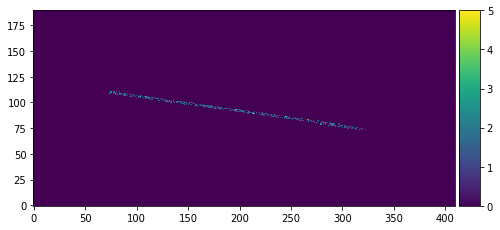

In [183]:
fig, ax = plt.subplots(figsize=(8, 8))
imshow_cb(im, ax)

In [184]:
# Rebin the image to its final resolution defined by `microscope_pixel_size`.

def rebin(arr, new_shape):
    shape = (new_shape[0], arr.shape[0] // new_shape[0],
             new_shape[1], arr.shape[1] // new_shape[1])
    return arr.reshape(shape).sum(-1).sum(1)

final_shape = np.array(im.shape) / pixel_size_ratio
assert int(final_shape[0]) == final_shape[0]
assert int(final_shape[1]) == final_shape[1]
final_shape = final_shape.astype('int')

im2 = rebin(im, final_shape)

# Also save the dimer positions in the new grid
positions[['x_pixel_final', 'y_pixel_final']] = positions.loc[:, ['x_pixel_fine', 'y_pixel_fine']] / pixel_size_ratio

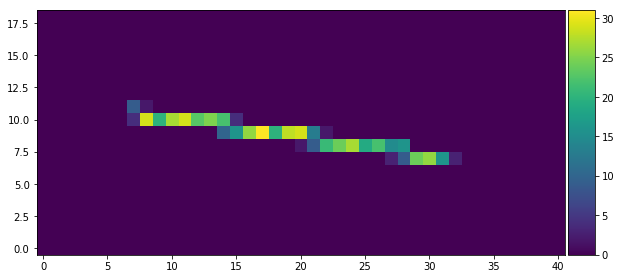

In [185]:
fig, ax = plt.subplots(figsize=(10, 10))
imshow_cb(im2, ax)

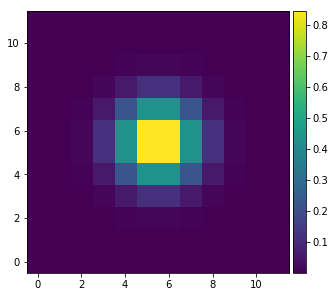

In [186]:
# Generate a microscope PSF

def generate_psf(kernel_size_pixel, sigma_pixel):
    from scipy import signal
    gaussian_kernel_1d = signal.gaussian(kernel_size_pixel, std=sigma_pixel)
    gaussian_kernel_1d = gaussian_kernel_1d.reshape(kernel_size_pixel, 1)
    gaussian_kernel_2d = np.outer(gaussian_kernel_1d, gaussian_kernel_1d)
    return gaussian_kernel_2d

psf_size = 135  # nm
sigma_pixel = psf_size / microscope_pixel_size

psf = generate_psf(int(sigma_pixel * 10), sigma_pixel)

fig, ax = plt.subplots(figsize=(5, 5))
imshow_cb(psf, ax)

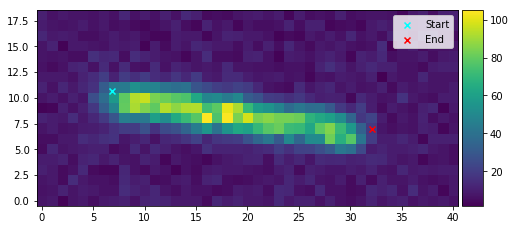

In [187]:
# Convolve image with PSF
from scipy import ndimage
im3 = ndimage.convolve(im2, psf, mode="constant")

# Add offset signal
im4 = im3 + im3.max() * 0.1

# Add noise
noise_factor = 10
noise = np.random.poisson(im4).astype(float) * noise_factor
im4 = im4 + noise
im4 /= 10

# Get the position of the start and end of the microtubule
selected_dimers = positions
indexed_positions = selected_dimers.set_index('row')
indices = np.sort(indexed_positions.index.unique())

first_dimers = indexed_positions.loc[indices[0], ['y_pixel_final', 'x_pixel_final']]
x_start, y_start = first_dimers.mean() - 0.5

last_dimers = indexed_positions.loc[indices[-5:], ['y_pixel_final', 'x_pixel_final']]
x_end, y_end = last_dimers.mean() - 0.5

fig, ax = plt.subplots(figsize=(8, 8))

imshow_cb(im4, ax)
ax.scatter([x_start], [y_start], color='cyan', label='Start', marker='x')
ax.scatter([x_end], [y_end], color='red', label='End', marker='x')
ax.legend()

In [144]:
import tifffile
tifffile.imsave("/home/hadim/test.tif", im4)

In [136]:
# Estimate the SNR by thresolding
signal_indices = np.where(im5 > 6000)
background_indices = np.where(im5 < 6000)
signal = im5[signal_indices]
bg = im5[background_indices]
snr = (signal.mean() - bg.mean()) / np.sqrt(signal.std()**2 + bg.std()**2)

In [ ]:
(7)